In [100]:
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import numpy as np
from datetime import datetime

# Reading Sensor Values

In [101]:
with open('ss_north_field_env_data.txt.txt') as f:
    sensor_values = [line.rstrip() for line in f]

In [102]:
df=pd.DataFrame()

# Creating a DataFrame object with Sensor Values

In [103]:
for line in sensor_values:
    s=line.split(',')
    dic = {}
    dic['Date']=s[0][0:19]
    for i in range(1,len(s)):
        a=s[i].split(':')
        a[0]=a[0].rstrip()
        a[0]=a[0].lstrip()
        a[1]=a[1].rstrip()
        a[1]=a[1].lstrip()
        dic[a[0]]=a[1]
    if int(dic['Intensity']) > 100:
        df=df.append(dic,ignore_index=True)

In [104]:
df.head()

,BME280_Humidity,BME280_Pressure,BME280_Temp,DS18B20_Temp,Date,Intensity
0,66.70,900.24,15.74,10.06,2019-10-26-07-25-58,155
1,66.72,900.29,15.74,10.88,2019-10-26-07-25-59,215
2,66.55,900.40,16.02,10.94,2019-10-26-07-41-07,215
3,66.10,900.59,16.60,11.44,2019-10-26-07-56-14,280
4,65.65,900.51,17.04,12.25,2019-10-26-08-11-21,431


# Changing Data-Types of each Column

In [105]:
df['Date']=pd.to_datetime(df['Date'],format='%Y-%m-%d-%H-%M-%S')
df['BME280_Humidity']=df['BME280_Humidity'].astype(float)
df['BME280_Pressure']=df['BME280_Pressure'].astype(float)
df['DS18B20_Temp']=df['DS18B20_Temp'].astype(float)
df['Intensity']=df['Intensity'].astype(float)
df['BME280_Temp']=df['BME280_Temp'].astype(float)

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   BME280_Humidity  983 non-null    float64       
 1   BME280_Pressure  983 non-null    float64       
 2   BME280_Temp      983 non-null    float64       
 3   DS18B20_Temp     983 non-null    float64       
 4   Date             983 non-null    datetime64[ns]
 5   Intensity        983 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 46.2 KB


# Reading the images between 1pm to 4pm 

In [107]:
image_file_names=glob.glob("./dataset/*.jpg")
image_file_names.sort()

In [108]:
image_file_names[0]

'./dataset/image2019-10-26-13-11-25.jpg'

In [109]:
dates=df.Date
dates=np.array(dates)

# Reading Dates of Sensor Values and Images

In [110]:
sensor_dates=[]
image_dates=[]
for i in range(len(dates)):
    s=str(dates[i]).split('T')
    x=list(s[0]+"-"+s[1][0:8])
    x[13]='-'
    x[16]='-'
    sensor_dates.append(''.join(x))

for filename in image_file_names:
    s=filename.lstrip('./dataset/image').rstrip('.jpg')[0:19]
    image_dates.append(s)

In [111]:
sensor_dates[0] ,image_dates[0]

('2019-10-26-07-25-58', '2019-10-26-13-11-25')

In [112]:
df.shape

(983, 6)

In [113]:
spinach_pixel_vals=np.array([0 for i in range(df.shape[0])])
potato_pixel_vals=np.array([0 for i in range(df.shape[0])])

# Spinach Pixel Count

In [114]:
def spinach_pixel_count(im,x,diff,z):
    im=im[500:2300,1:1200]
    count=0;
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if int(im[i][j][0] + diff[0]) > (x[0]+z[0]) and int(im[i][j][1] + diff[1]) > (x[1]+z[1]) and int(im[i][j][2] + diff[2]) > (x[2]+z[2]) :
                count+=1;
    return count

# Potato Pixel Count

In [115]:
def potato_pixel_count(im,x,diff,z):
    im=im[650:2163,1504:2608]
    count=0;
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if int(im[i][j][0] + diff[0]) > (x[0]+z[0]) and int(im[i][j][1] + diff[1]) > (x[1]+z[1]) and int(im[i][j][2] + diff[2]) > (x[2]+z[2]) :
                count+=1;
    return count

# Funtion to Calculate the average [r,g,b] values of a window where first time Spinach Leaf appeared.

In [116]:
def avgofcrop(im):
    r=0.0;
    g=0.0;
    b=0.0;
    im=im[920:930,442:450]
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            r+=int(im[i][j][0])
            g+=int(im[i][j][1])
            b+=int(im[i][j][2])
            
    tp = (im.shape[0] * im.shape[1])
    l=[]
    l.append(r/tp)
    l.append(g/tp)
    l.append(b/tp)
    return l

# Function to Calculate the average [r,g,b] values of a window where in the end soil was present

In [117]:
def avgofsoil(im):
    r=0.0;
    g=0.0;
    b=0.0;
    im=im[1780:1920,200:400]
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            r+=int(im[i][j][0])
            g+=int(im[i][j][1])
            b+=int(im[i][j][2])
            
    tp = (im.shape[0] * im.shape[1])
    l=[]
    l.append(r/tp)
    l.append(g/tp)
    l.append(b/tp)
    return l

# Function to Calculate difference between [r,g,b] values of crop and soil

In [118]:
def difference(a,b):
    ans=[]
    ans.append(abs(a[0]-b[0]))
    ans.append(abs(a[1]-b[1]))
    ans.append(abs(a[2]-b[2]))
    return ans;

In [119]:
valid=np.array([0 for i in range(df.shape[0])])

In [120]:
z=[40,40,40]
for idx,filedate in enumerate(sensor_dates): 
    if filedate in image_dates:
        filename='./dataset/image'+filedate+'.jpg'
        image=plt.imread(filename)
        x=avgofcrop(image)
        y=avgofsoil(image)
        if(sum(x) < sum(y)):
            continue
        diff=difference(x,y)
        ans1=spinach_pixel_count(image,x,diff,z)
        ans2=potato_pixel_count(image,x,diff,z)
        spinach_pixel_vals[idx]=ans1
        potato_pixel_vals[idx]=ans2
        valid[idx]=1

In [121]:
df['Spinach_Area']=spinach_pixel_vals
df['Potato_Area']=potato_pixel_vals

In [122]:
df['Valid']=valid


In [128]:
df.head(25)

,BME280_Humidity,BME280_Pressure,BME280_Temp,DS18B20_Temp,Date,Intensity,Spinach_Area,Potato_Area,Valid
0,66.70,900.24,15.74,10.06,2019-10-26 07:25:58,155.0,0,0,0
1,66.72,900.29,15.74,10.88,2019-10-26 07:25:59,215.0,0,0,0
2,66.55,900.40,16.02,10.94,2019-10-26 07:41:07,215.0,0,0,0
3,66.10,900.59,16.60,11.44,2019-10-26 07:56:14,280.0,0,0,0
4,65.65,900.51,17.04,12.25,2019-10-26 08:11:21,431.0,0,0,0
5,64.49,900.51,18.28,13.12,2019-10-26 08:26:28,700.0,0,0,0
6,63.62,900.78,19.22,13.19,2019-10-26 08:41:36,1024.0,0,0,0
7,62.92,900.85,20.22,14.25,2019-10-26 08:56:43,1126.0,0,0,0
8,61.86,900.97,20.94,15.12,2019-10-26 09:11:50,1369.0,0,0,0
9,61.10,900.95,21.94,16.19,2019-10-26 09:26:57,1509.0,0,0,0


In [129]:
index=df[df.Valid==0].index
df=df.drop(index)

In [130]:
df.to_csv('Weather_vs_Pixel_Area.csv')
df.head()

,BME280_Humidity,BME280_Pressure,BME280_Temp,DS18B20_Temp,Date,Intensity,Spinach_Area,Potato_Area,Valid
22,54.00,898.84,30.25,23.62,2019-10-26 13:11:25,2011.0,126,890,1
23,54.04,898.64,30.02,23.62,2019-10-26 13:26:32,1797.0,398,1413,1
24,53.66,898.40,29.86,23.19,2019-10-26 13:41:39,1694.0,244,962,1
25,53.50,898.20,29.96,23.25,2019-10-26 13:56:47,1614.0,1159,2538,1
26,53.42,898.04,29.93,22.81,2019-10-26 14:11:54,1512.0,324,2880,1


In [132]:
df = df.drop('Valid', 1)

In [136]:
df.head()

,BME280_Humidity,BME280_Pressure,BME280_Temp,DS18B20_Temp,Date,Intensity,Spinach_Area,Potato_Area
22,54.00,898.84,30.25,23.62,2019-10-26 13:11:25,2011.0,126,890
23,54.04,898.64,30.02,23.62,2019-10-26 13:26:32,1797.0,398,1413
24,53.66,898.40,29.86,23.19,2019-10-26 13:41:39,1694.0,244,962
25,53.50,898.20,29.96,23.25,2019-10-26 13:56:47,1614.0,1159,2538
26,53.42,898.04,29.93,22.81,2019-10-26 14:11:54,1512.0,324,2880


In [137]:
df.to_csv('Weather_vs_Pixel_Area.csv')

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 22 to 979
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   BME280_Humidity  250 non-null    float64       
 1   BME280_Pressure  250 non-null    float64       
 2   BME280_Temp      250 non-null    float64       
 3   DS18B20_Temp     250 non-null    float64       
 4   Date             250 non-null    datetime64[ns]
 5   Intensity        250 non-null    float64       
 6   Spinach_Area     250 non-null    int64         
 7   Potato_Area      250 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 17.6 KB


In [139]:
import seaborn as sns

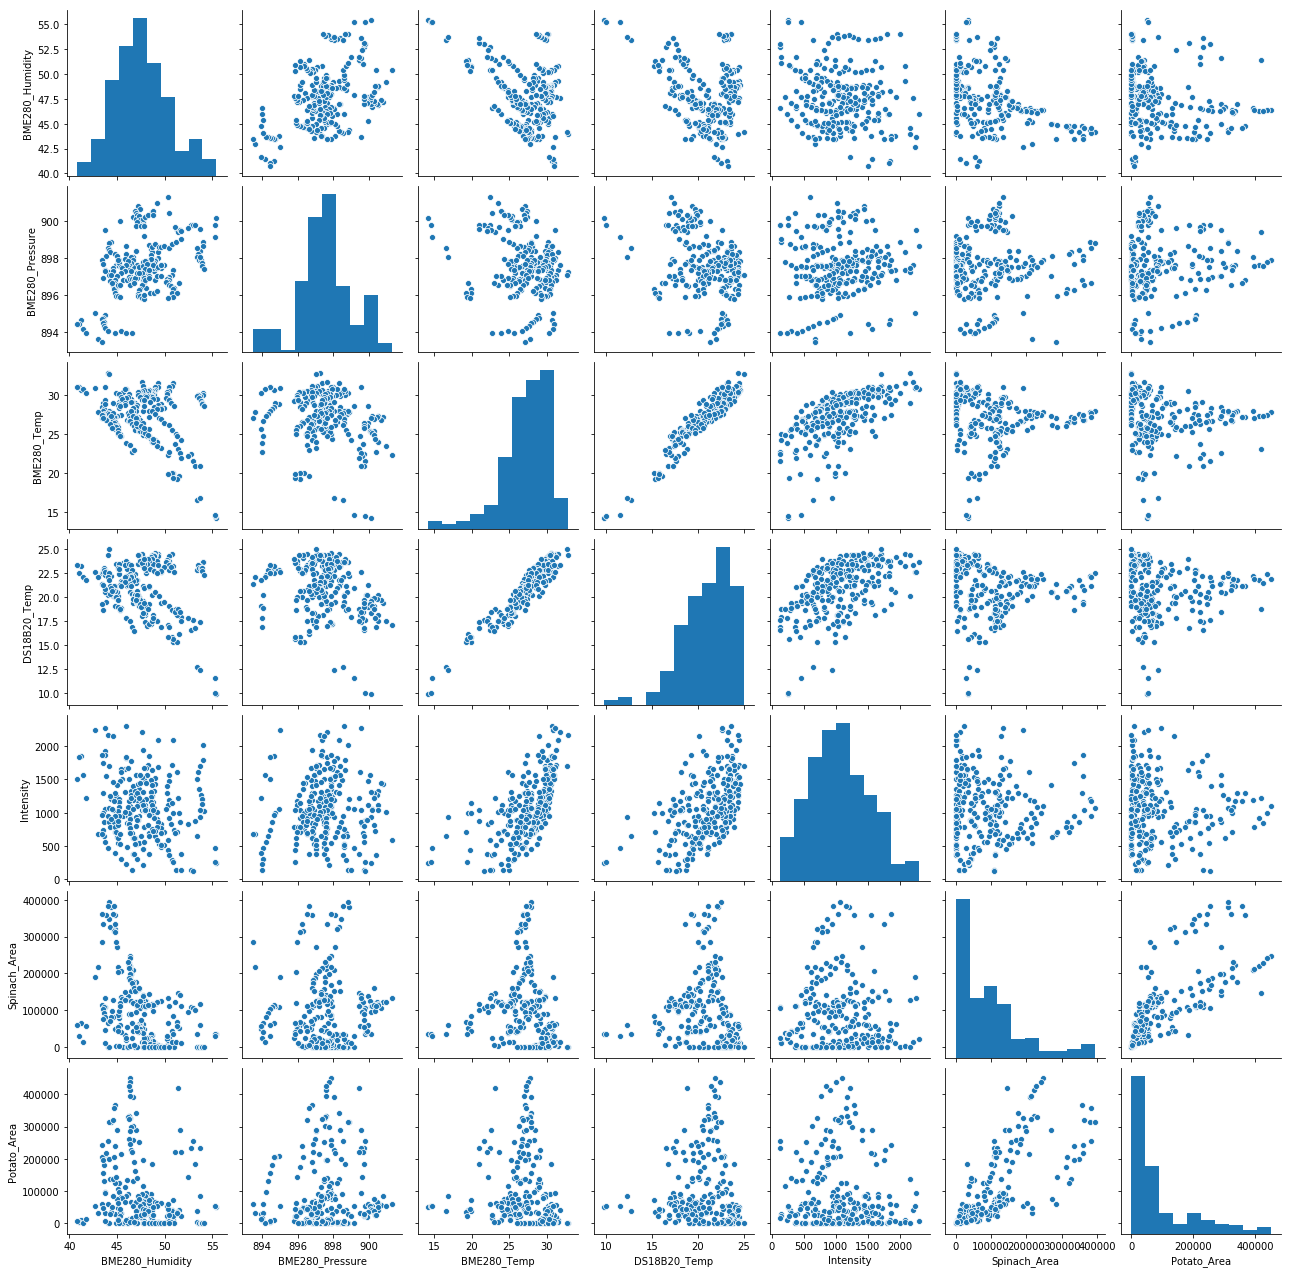

In [140]:
sns.pairplot(df)

In [141]:
cor=df.corr()
round(cor,3)

,BME280_Humidity,BME280_Pressure,BME280_Temp,DS18B20_Temp,Intensity,Spinach_Area,Potato_Area
BME280_Humidity,1.000,0.426,-0.365,-0.284,-0.183,-0.448,-0.226
BME280_Pressure,0.426,1.000,-0.242,-0.282,0.042,0.040,0.064
BME280_Temp,-0.365,-0.242,1.000,0.952,0.613,-0.172,-0.163
DS18B20_Temp,-0.284,-0.282,0.952,1.000,0.511,-0.167,-0.095
Intensity,-0.183,0.042,0.613,0.511,1.000,-0.024,-0.064
Spinach_Area,-0.448,0.040,-0.172,-0.167,-0.024,1.000,0.750
Potato_Area,-0.226,0.064,-0.163,-0.095,-0.064,0.750,1.000


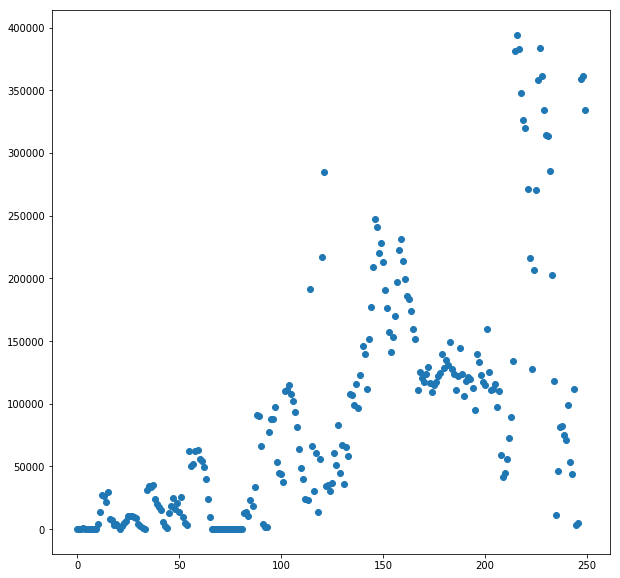

In [146]:
tx1=np.array(df.Spinach_Area)
tx2=np.array(df.Potato_Area)
c=[i for i in range(len(tx1))]
plt.figure(figsize=(10,10))
# f.add_subplot(1,2,1)
plt.scatter(c,tx1)
# f.add_subplot(1,2,2)
plt.show()

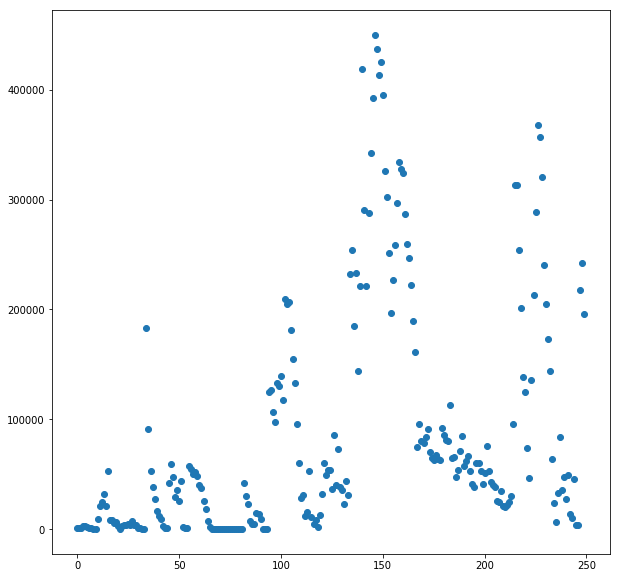

In [147]:
plt.figure(figsize=(10,10))
plt.scatter(c,tx2)
plt.show()